In [1]:
from src import kernel

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1

/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/root/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Kernel ABC

**Dataload**

実測データは、観測値$\left\{(X_1,Y_1),(X_2,Y_2),...,(X_n,Y_n)\right\}$で表される。   
Simulatorは, 
$\theta_0 \geq x$が成り立つ条件では、$\theta_1+\theta_2 x$を出力し、   
$\theta_0 > x$が成り立つ条件では、$\theta_3+\theta_4 x$を出力する。
つまり, 入力$x$に対して、    
\begin{eqnarray}
    y = \left\{ \begin{array}{ll}
          \theta_1+\theta_2 x& (x > \theta_0) \\
          \theta_3+\theta_4 x& (x \geq \theta_0)
  \end{array} \right.
\end{eqnarray}    
に従う$y$を出力する。

SimulatorのkABCパラメタ推定は、あらかじめ$\theta$の異なる入出力データを作成する。    
$\left\{\{X^{m}_1, Y^{m}_1, \theta_m \},...,\{X^{m}_n, Y^{m}_n, \theta_m \}\right\} \, n=0,...,N \, m=0,...,M$

src/kernel/data/data_generator.ipynb を参照

In [2]:
def SimModel(x,params):
    x1 = x[x>params[0]] #x > partition
    x2 = x[~(x>params[0])] # x<= partition
    y1 = params[3]+params[4]*x1 
    y2 = params[1]+params[2]*x2
    return np.r_[y2,y1]

In [3]:
df_sim = pd.read_csv('./src/kernel/data/test_simulation_data.csv')
df_obs = pd.read_csv('./src/kernel/data/test_observation_data.csv')

In [4]:
print(df_sim.head())
print(df_obs.head())

          x          y    param0     param1    param2     param3    param4
0  0.000000  10.641638  7.547481  10.641638 -7.514077 -15.510451  4.557274
1  0.204082   9.108152  7.547481  10.641638 -7.514077 -15.510451  4.557274
2  0.408163   7.574667  7.547481  10.641638 -7.514077 -15.510451  4.557274
3  0.612245   6.041183  7.547481  10.641638 -7.514077 -15.510451  4.557274
4  0.816327   4.507697  7.547481  10.641638 -7.514077 -15.510451  4.557274
          x          y
0  0.000000  15.000000
1  0.204082  14.387755
2  0.408163  13.775511
3  0.612245  13.163265
4  0.816327  12.551020


**Make DataSet**

In [5]:
ABC_Dataset = kernel.utils.ABCDataSet(df_sim,['param0','param1','param2','param3','param4'],df_obs,['y'])

In [6]:
ABC = kernel.ABC(Dataset=ABC_Dataset,
                 sigma_y='silverman',
                 sigma_para='silverman')

In [7]:
y = SimModel(ABC_Dataset.row_obs.loc[:,'x'].values,ABC.posterior_mean().loc['mean'].values)

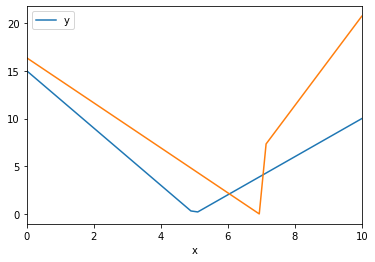

In [8]:
ABC_Dataset.row_obs.plot('x','y')
plt.plot(ABC_Dataset.row_obs.loc[:,'x'],y)

## Simple dataset

In [9]:
def SimModel2(x,param):
    y = (x*0.2).astype(int)*param[0] + param[1]*np.sqrt(x).astype(int)
    return y

In [10]:
X = np.arange(0,50,1.)
Y_obs = SimModel2(X,[2,10])

obs_data = pd.DataFrame({'x':X,'y':Y_obs})

param_set = []
np.random.seed(1)
for i in range(30):
    param_set.append([float(np.random.randint(0,20)),float(np.random.randint(0,20))])

df = pd.DataFrame()
for i,param in enumerate(param_set):
    
    Y = SimModel2(X,param)
    df = pd.concat([df,pd.DataFrame({'x':X.astype(float),
                                     'y':Y.astype(float),
                                     'para0':float(param[0]),
                                     'para1':float(param[1])})])

In [11]:
dataset = kernel.utils.ABCDataSet(prior_samples=df,
                                  parameter_keys=['para0','para1'],
                                  observed_samples=obs_data,
                                  data_key=['y'])

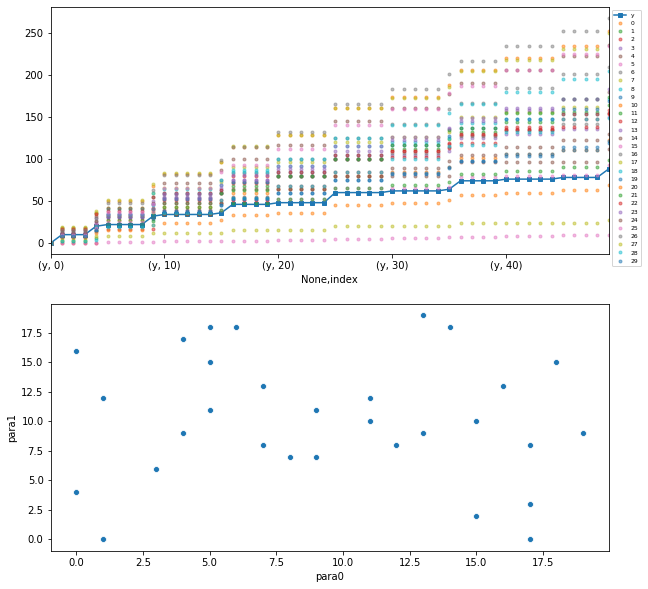

In [12]:
fig = plt.figure(figsize=[10,10])
ax1 = fig.add_subplot(211)
dataset.observed_samples.T.plot(marker='s',ax=ax1,ms=4,legend=False)
dataset.prior_data.T.plot(marker='o',linestyle='',ax=ax1,alpha=0.5,ms=3,legend=False)
ax1.legend(bbox_to_anchor=(1,1),loc='upper left',fontsize=6)

ax2 = fig.add_subplot(212)
sns.scatterplot(data=dataset.parameters,x='para0',y='para1')
fig.show()

**KerenelABC**

In [13]:
ABC = kernel.ABC(Dataset=dataset,
                 sigma_y='silverman',
                 sigma_para='silverman')

In [14]:
KM_prior = kernel.Mean(ABC.Dataset.parameters,sigma='silverman')
KM_post = ABC.posterior_kernel()
x = np.arange(0,20.,1.)
y = np.arange(0,20.,1.)
xx,yy = np.meshgrid(x,y)
z_prior = KM_prior.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
z_prior = z_prior.reshape(xx.shape[0],-1)
z_post = KM_post.mu_p(np.array([xx.ravel(),yy.ravel()]).T)
z_post = z_post.reshape(xx.shape[0],-1)

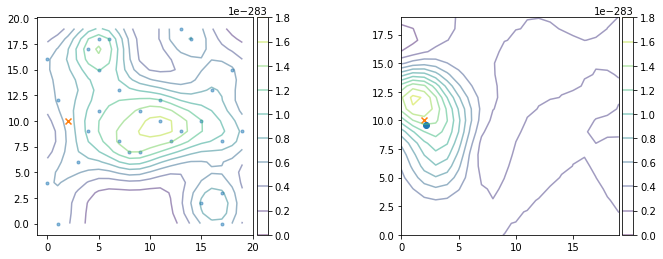

In [15]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)
cbar1 = ax1.contour(xx,yy,z_prior,10,alpha=0.5)
ax1.scatter(
    ABC.Dataset.parameters.loc[:,'para0'],
    ABC.Dataset.parameters.loc[:,'para1'],
    alpha=0.5,marker='.')
ax1.scatter(2,10,marker='x')
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(122)
cbar2 = ax2.contour(xx,yy,z_post,10,alpha=0.5)
ax2.scatter(2,10,marker='x',label='True',color='C1')
ax2.scatter(ABC.posterior_mean().para0,
            ABC.posterior_mean().para1,
            marker='o',label='predict')
ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)
fig.show()

In [16]:
KH = kernel.Herding(obj_KernelMean=ABC.posterior_kernel())

In [17]:
supersample = KH.supersample(
                sample_size=10, 
                optimizer='scipy_optim',method='powell')

'    100% |################################| 0day  0:00:00 Total time: 0day  0:00:00'

In [18]:
z_post_herding = KH.approximation_mean(np.array([xx.ravel(),yy.ravel()]).T)
z_post_herding = z_post_herding.reshape(xx.shape[0],-1)

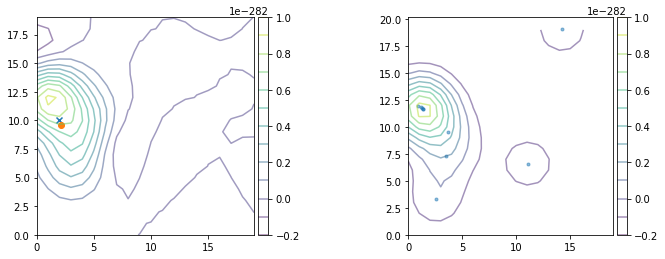

In [19]:
fig = plt.figure(figsize=[12,4])
ax1 = fig.add_subplot(121)
cbar1 = ax1.contour(xx,yy,z_post,10,alpha=0.5)
ax1.scatter(2,10,marker='x')
ax1.scatter(ABC.posterior_mean().para0,
            ABC.posterior_mean().para1,
            marker='o',label='predict')
ax1.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax1)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)

ax2 = fig.add_subplot(122)
cbar2 = ax2.contour(xx,yy,z_post_herding,10,alpha=0.5)
ax2.scatter(
    supersample[:,0],
    supersample[:,1],
    alpha=0.5,marker='.')

ax2.axis("image")
divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax2)
cax = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(cax)
fig.colorbar(cbar1,cax=cax)
fig.show()

**simulation**

In [20]:
df_pred = pd.DataFrame()
for i,param in enumerate(supersample):
    
    Y = SimModel2(X,param)
    df_pred = pd.concat([df_pred,
                         pd.DataFrame({'x':X.astype(float),
                                       'y':Y.astype(float),
                                       'para0':float(param[0]),
                                       'para1':float(param[1])})])

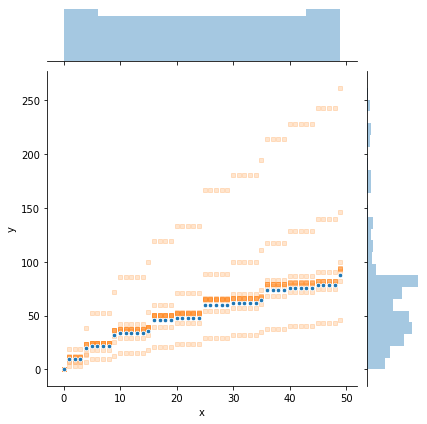

In [21]:
g = sns.jointplot(x="x", y="y", data=df_pred)
g.plot_joint(plt.scatter, c="C1", s=20, linewidth=1, marker="s",alpha=0.2)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$")
sns.scatterplot(obs_data.x,obs_data.y,marker='o',s=20)

In [22]:
supersample.mean(axis=0)

array([ 4.11205279, 10.46495607])

In [23]:
sig_theta = kernel.utils.functions.get_band_width(dataset.parameters,method='silverman')
G_theta_cls  = kernel.utils.functions.gram_matrix(dataset.parameters,sig_theta)
G_theta = G_theta_cls.gram_matrix.copy()
weight = ABC.w.copy()
k_pri = ABC.Dataset.prior_data.values.copy()

In [24]:
def dens_y(y):
    return np.dot(np.dot(weight.T,np.dot(G_theta.T,G_theta.T)),ABC.kernel.compute(k_pri,y))

In [58]:
param_set_test = []
np.random.seed(1)
for i in range(100):
    param_set_test.append([float(np.random.randint(0,20)),float(np.random.randint(0,20))])

df_test = pd.DataFrame()
for i,param in enumerate(param_set_test):
    
    Y = SimModel2(X,param)
    df_test = pd.concat([df_test,pd.DataFrame({'y':Y.astype(float)}).T])

In [59]:
for i in range(100):
    df_test = pd.concat([df_test,pd.DataFrame({'y':np.array([np.random.randint(-300,300) for i in range(50)])}).T])

In [60]:
df_test = df_test.reset_index(drop=True)

In [61]:
pd_predict_y = pd.DataFrame()
for i,row in df_test.iterrows():
    dens = dens_y(row.values)
    pd_predict_y = pd.concat([pd_predict_y,pd.DataFrame({'y':[row.values],'p_yx':dens.squeeze()})])
pd_predict_y.p_yx= (pd_predict_y.p_yx-pd_predict_y.p_yx.min())/(pd_predict_y.p_yx.max()-pd_predict_y.p_yx.min())
pd_predict_y = pd_predict_y.reset_index(drop=True)

In [62]:
hoge_x, hoge_y, hoge_z = [],[],[]
for i, row in pd_predict_y.iterrows():
    hoge_x.append(X)
    hoge_y.append(row.y)
    hoge_z.append([row.p_yx]*50)

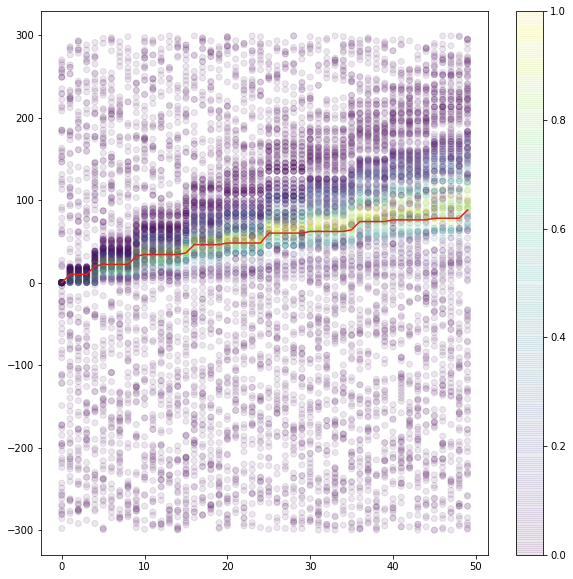

In [64]:
plt.figure(figsize=[10,10])
plt.scatter(x=np.array(hoge_x).ravel(),y=np.array(hoge_y).ravel(),c=np.array(hoge_z).ravel(),alpha=0.1)
plt.plot(X,Y_obs,'-',color='C3')
plt.colorbar()